# Exam Exercise

We will use the hls4ml dataset, that inclides simulations of jets produced in LHC collisions.

Jets are cone-shaped sprays of particles produced when gluons or quarks emerge from LHC collisions: quarks and gluons cannot live alone, so they start a shower of other quarks and gluons that then combine among themseles to give the stable particles that we observe in the detector.

Jets can be produced from the deacy of heavy particles, like W boson and Z boson (decaying to pairs of quarks), Higgs bosons (decaying to pairs of quarks), or top quark (decaying to three quarks). When a heavy particle is produced with large momentum, the jets it produces overlap and merge into a single jet, that looks different because of its different internal structure.

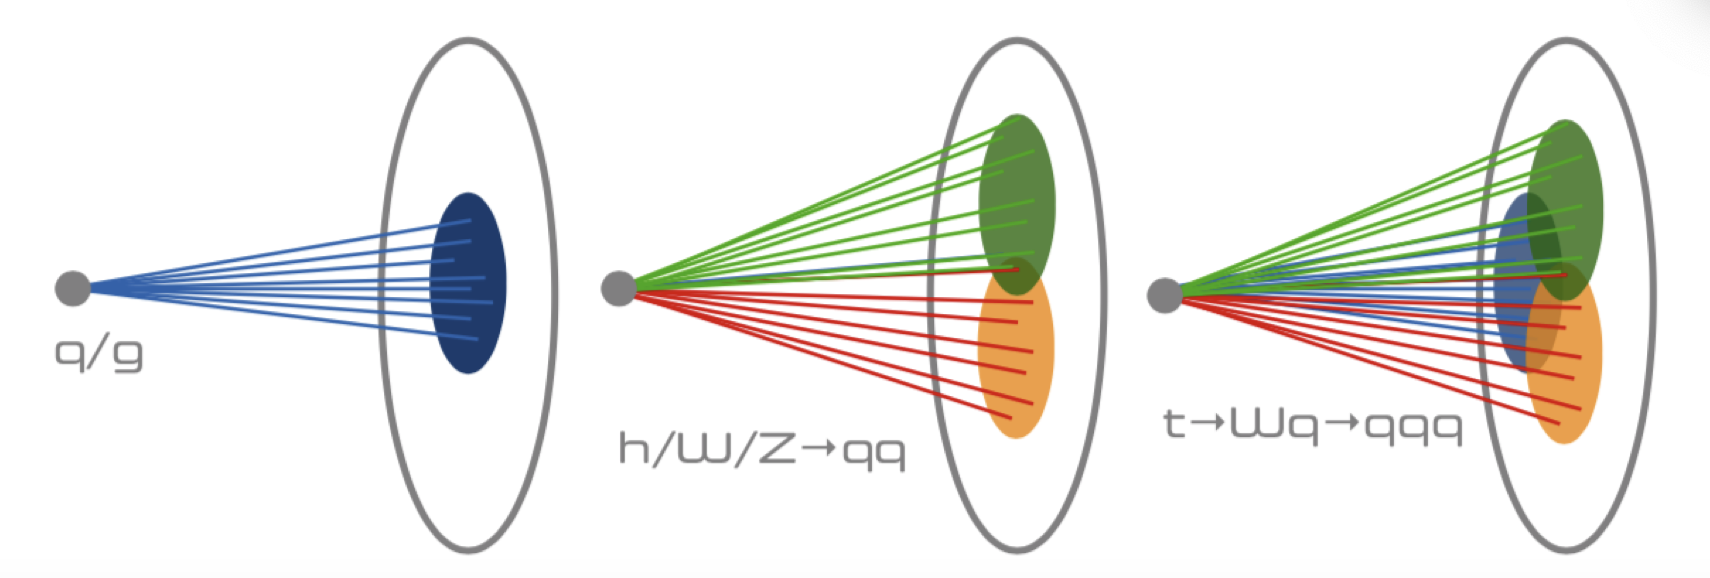

The data are provided in three formats:
- high-level features: an array of physics informed features, engineered to discriminate among the various particles
- Jets as images: a pixelated image of the jet, obtained binning the plane transverse to the jet flight direction and counting the total momentum of the final-state particles flowing in that bin
- Jets as sequence: a list of the particles in the jet, ordered in decreasing momentum, each characterized through a list of physics-informed and particle-specific features

The exercise is divided in two tasks:
- Train  a classifier to identify which particle generated the jets (a task called jet tagging), choosing among the following five possibilities: gluons (g), quarks (q), W bosons (W), Z bosons (Z), and top quarks (t). For this task, you should provide a successful training history, a ROC curve plot with the five classes projected, and a confusion matrix.
- Train an AE on quarks and gluons, to identify W, Z and t jets as anomalies. For this task, you should provide a successful training history, a plot showing the distribution of the loss for the standard jets and for the three anomaly classes, and a ROC curve plot with the three anomaly classes.

You can use one or more data representations at once. The examples in the datasets are in sync (the i-th entry of each dataset corresponds to the same jet) and the ground truth refers to all of them.

The rest of this notebook give you some hint on how to handle the datasets.

In [1]:
# Get the data
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

Cloning into 'tutorials'...
remote: Enumerating objects: 854, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 854 (delta 120), reused 271 (delta 116), pack-reused 579 (from 1)
Receiving objects: 100% (854/854), 678.55 MiB | 4.00 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Updating files: 100% (96/96), done.
jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Open one file
fileIN = 'tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


The first 100 highest-momentum particles are considered for each jet
- 'jetImage' contains the image representation of the jets (more later)
- 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)
- 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored
- 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
- 'jets' is the dataset we consider for the moment
- 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'

# The Groung Truth

The ground truth is one-hot encoded in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] format, so that
- [1, 0, 0, 0, 0] for gluons
- [0, 1, 0, 0, 0] for quarks
- [0, 0, 1, 0, 0] for Ws
- [0, 0, 0, 1, 0] for Zs
- [0, 0, 0, 0, 1] for tops
The information is contained at the end of the feature vector

In [10]:
jet_data = np.array(f.get('jets'))
target = jet_data[:,-6:-1]
# shape of the dataset
print("Dataset shape:")
print(target.shape)
print("First five entries:")
for i in range(5):
    print(target[i])
print("Last 5 entries:")
for i in range(-5,0):
    print(target[i])

Dataset shape:
(10000, 5)
First five entries:
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
Last 5 entries:
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]


# The physics-informed high-level features

In [11]:
# These are the quantities we are dealing with
featurenames = f.get('jetFeatureNames')
print(featurenames[:])
# the b is due to the byte vs utf-8 encoding of the strings in the dataset
# just ignore them for the moment

[b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'j_t' b'j_undef']


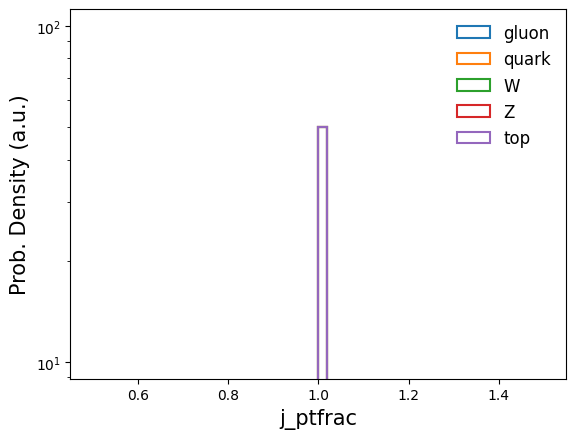

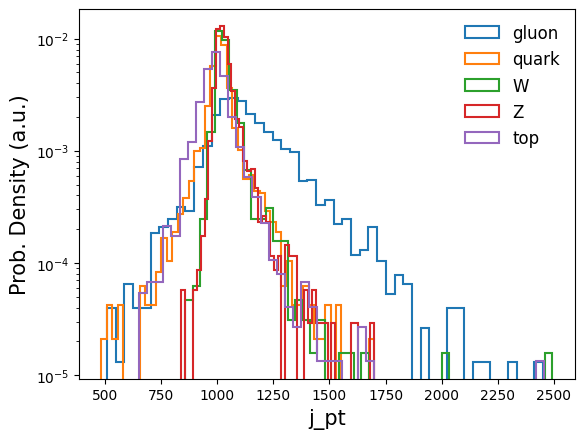

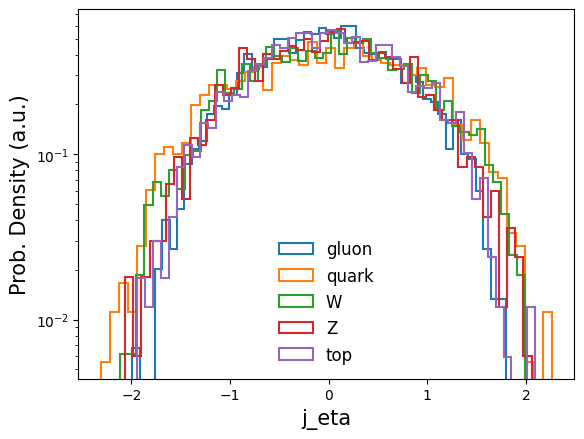

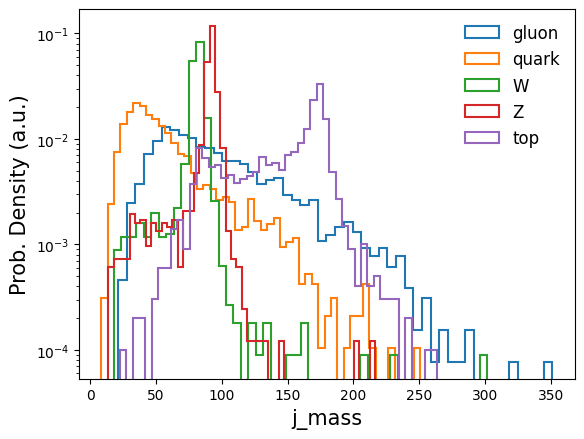

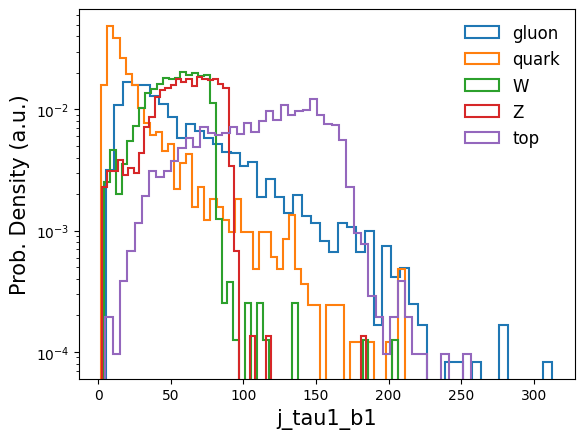

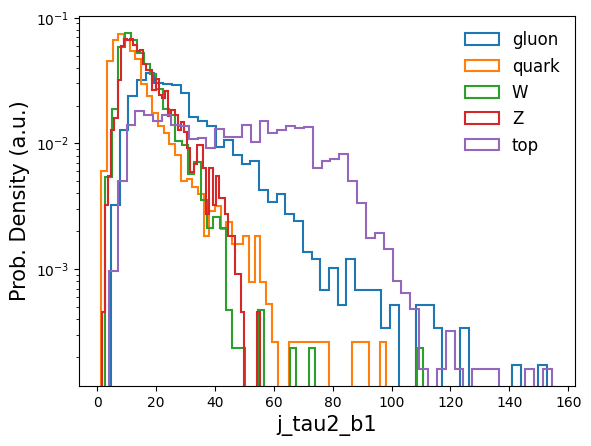

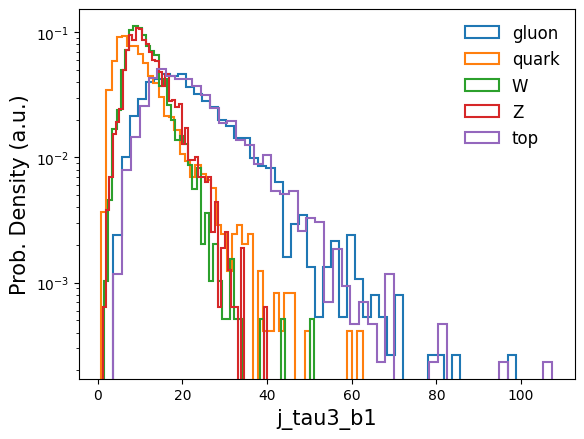

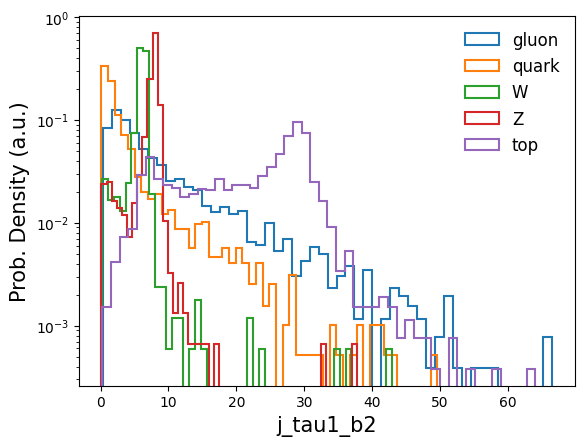

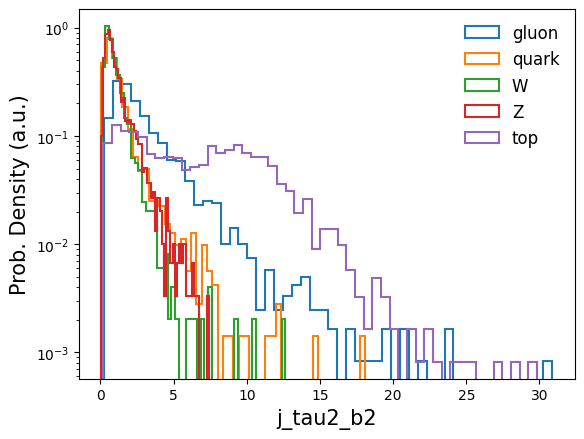

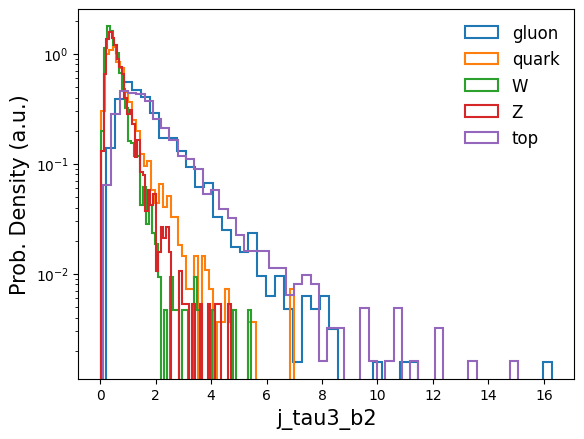

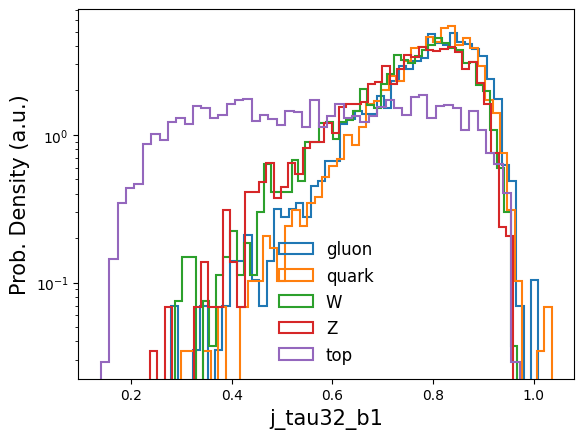

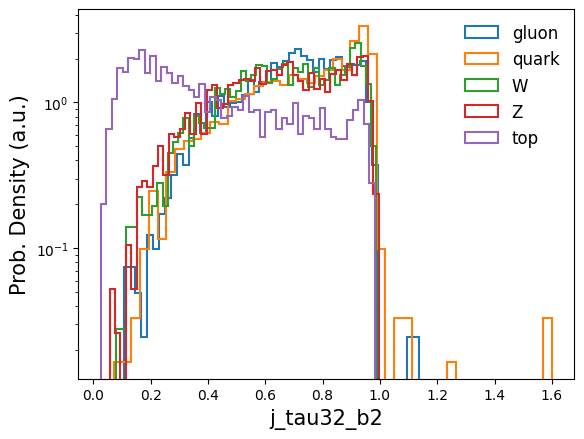

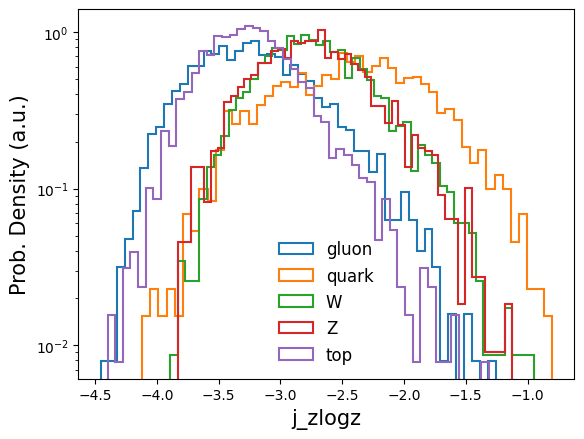

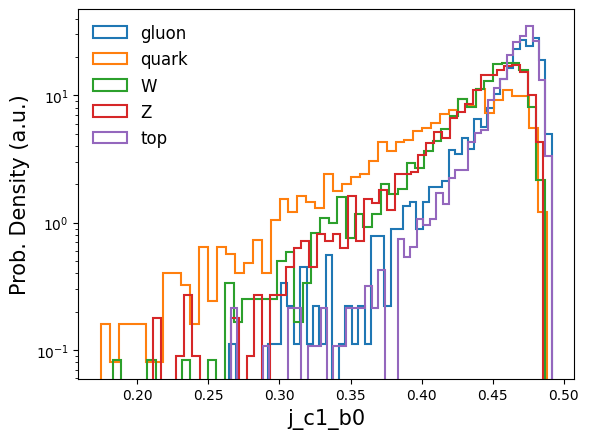

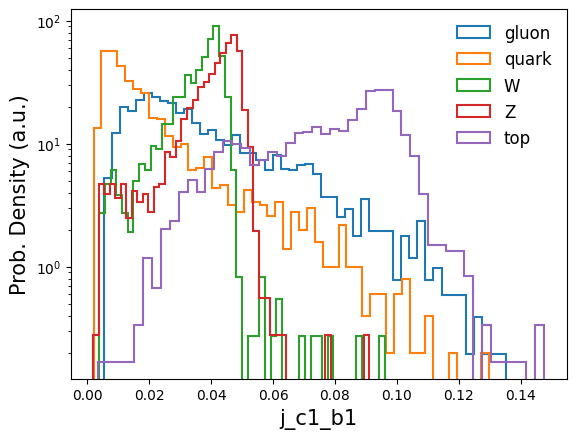

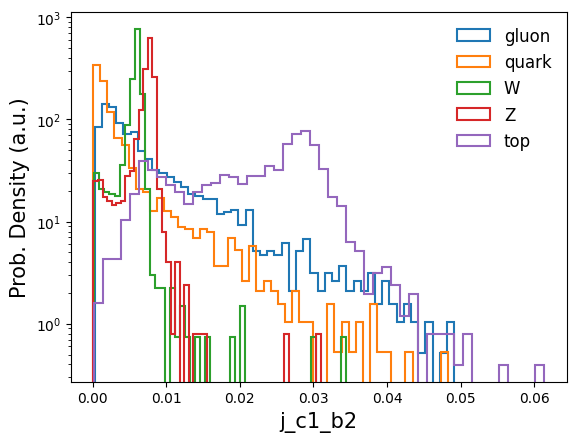

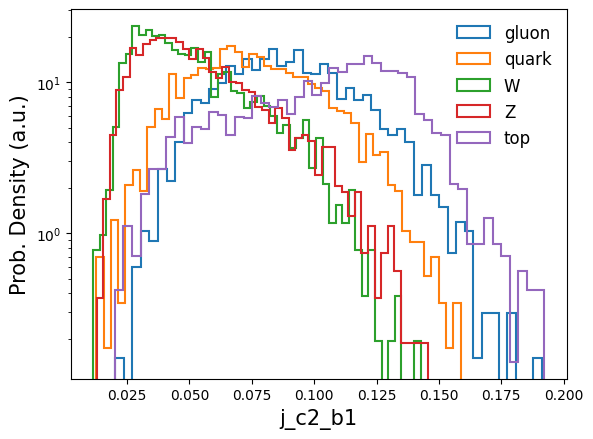

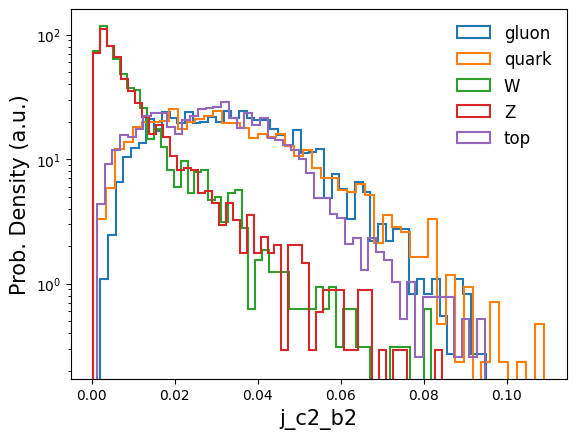

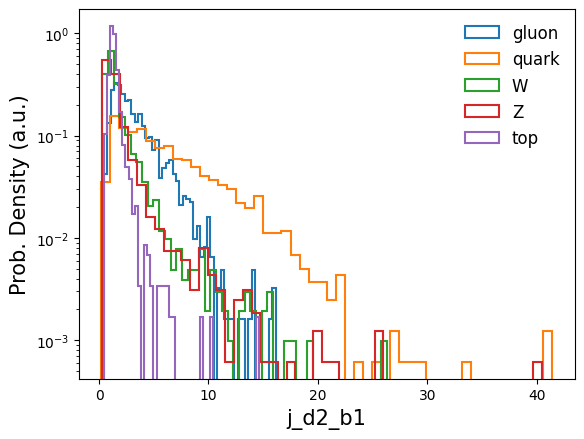

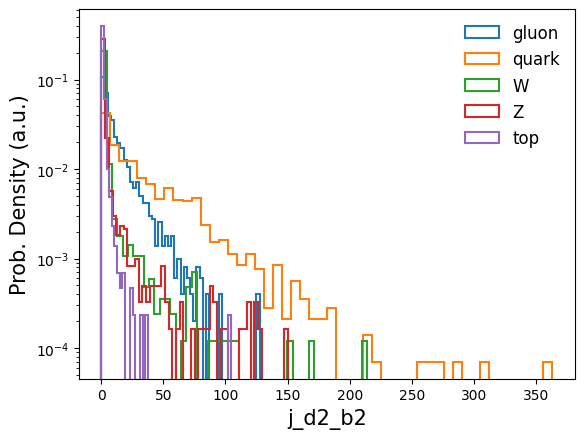

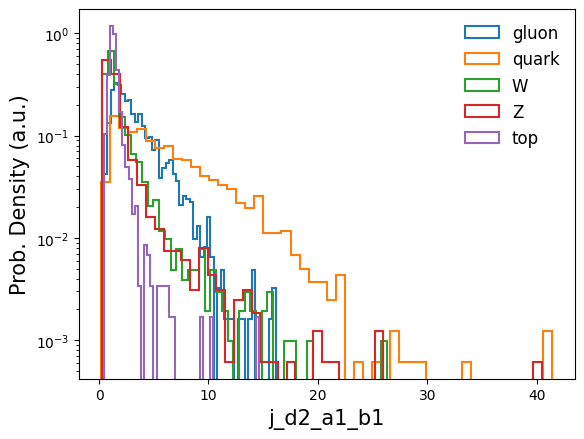

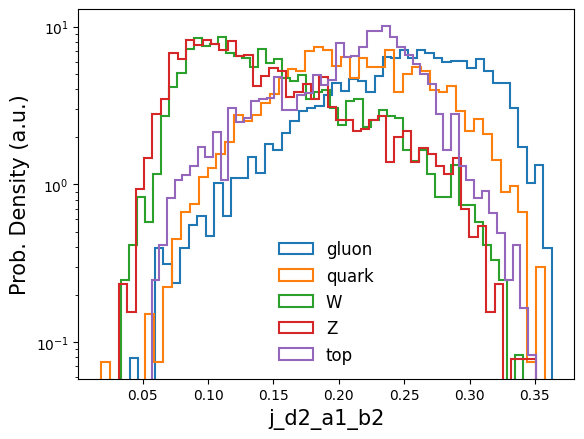

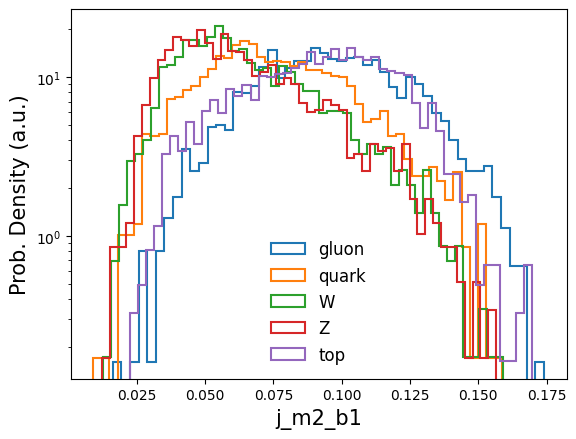

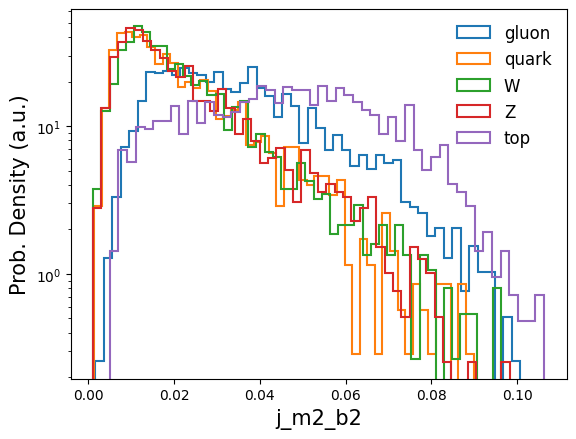

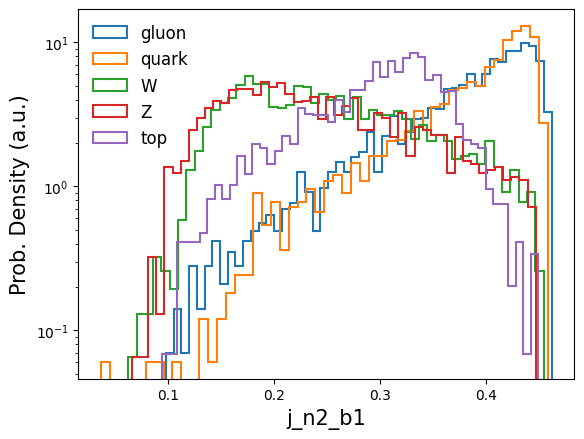

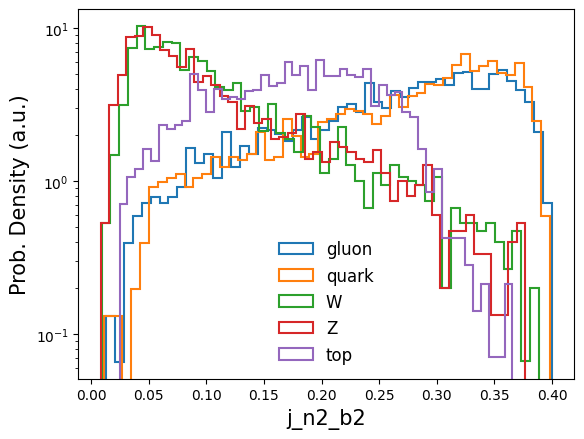

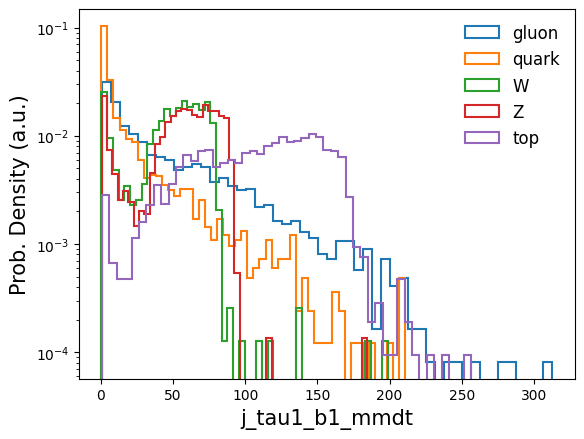

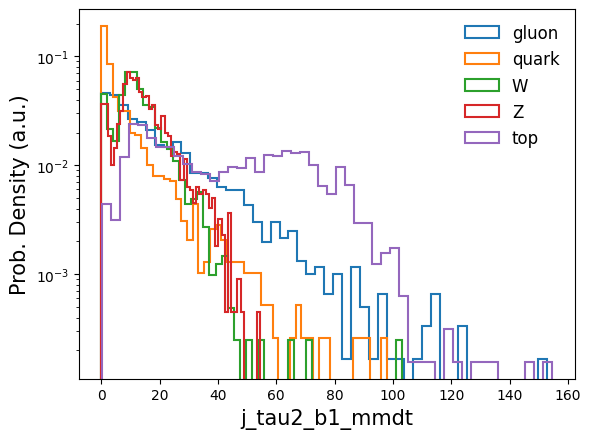

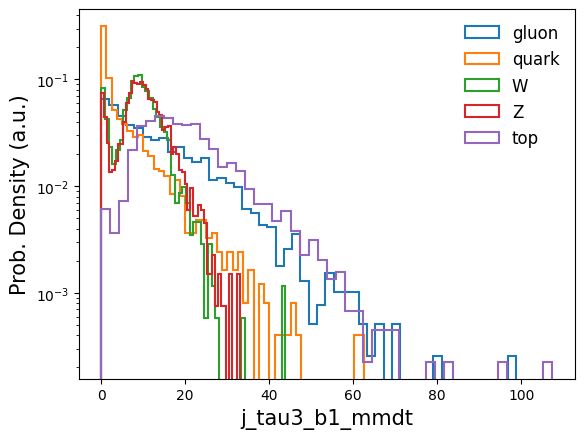

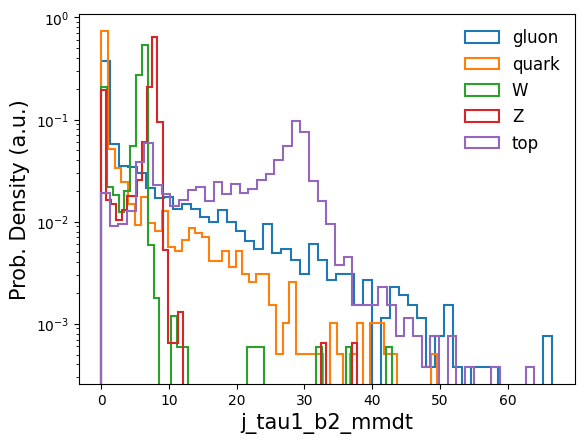

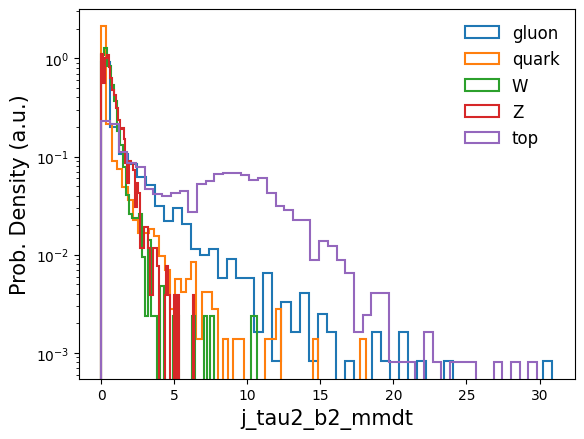

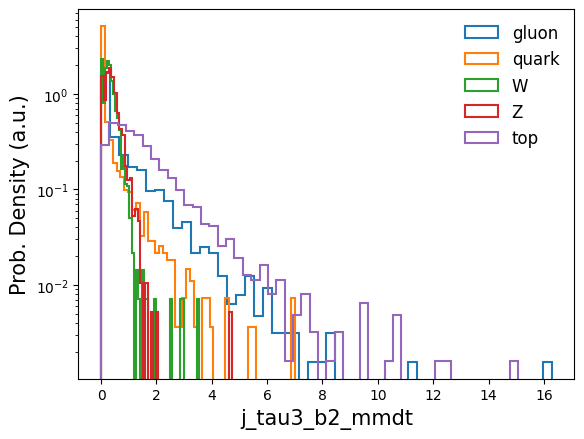

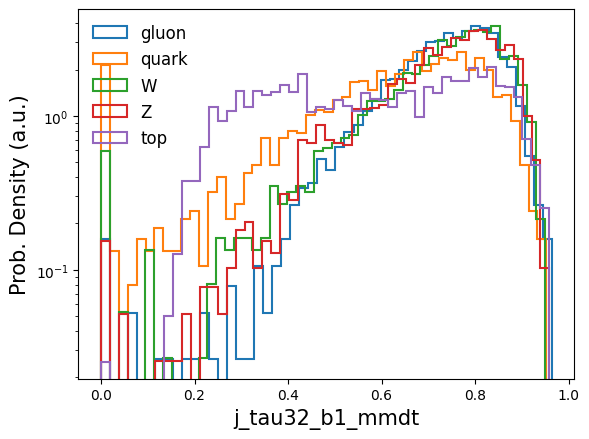

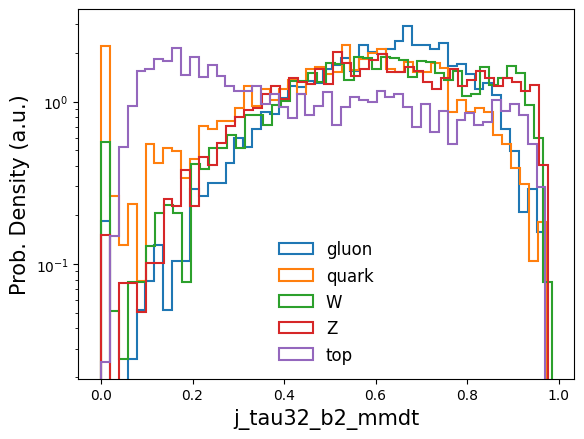

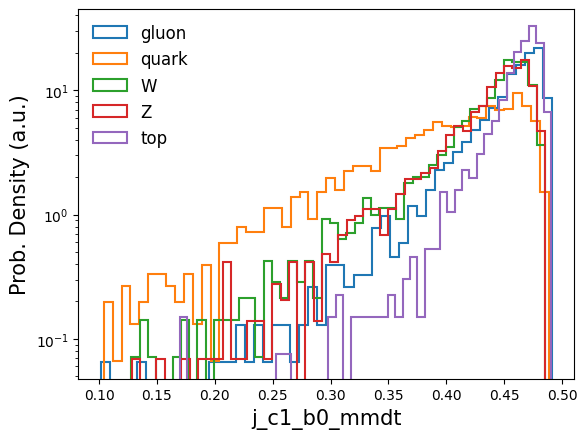

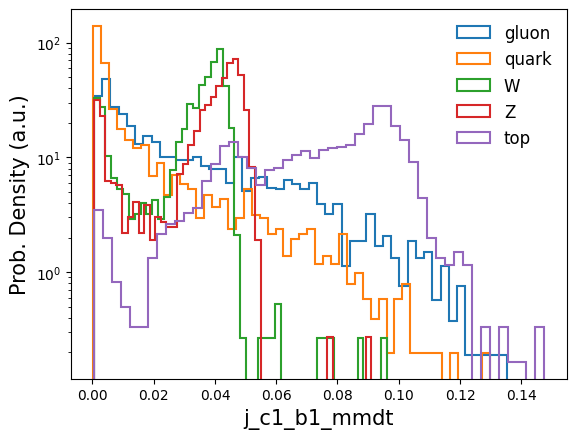

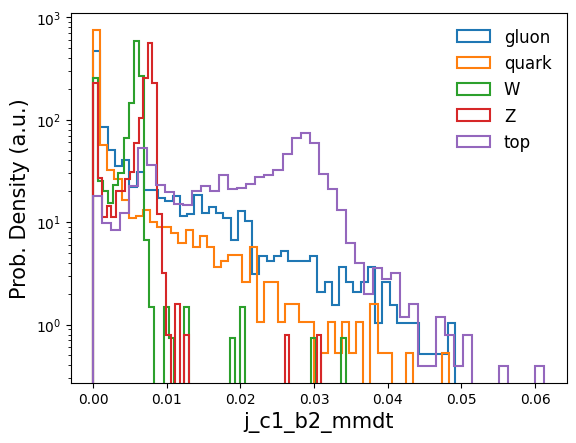

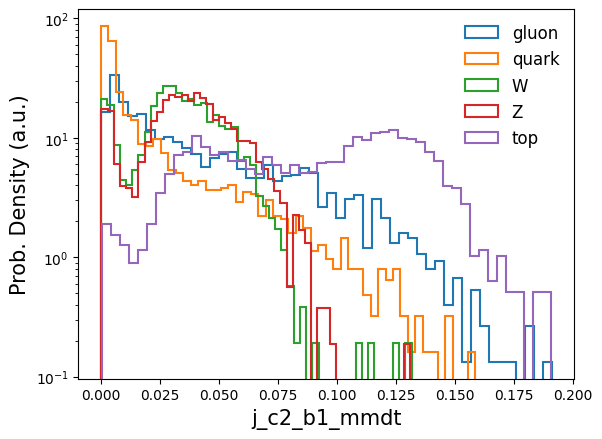

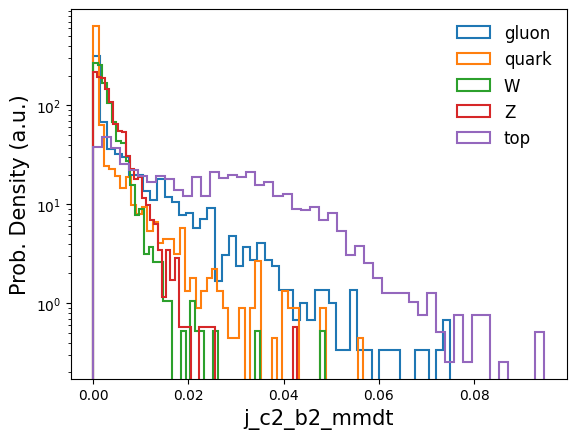

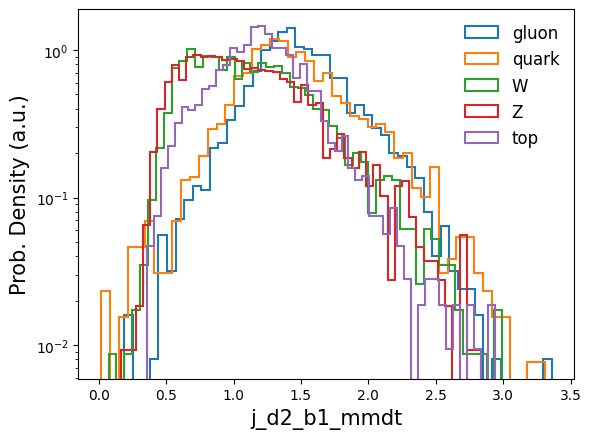

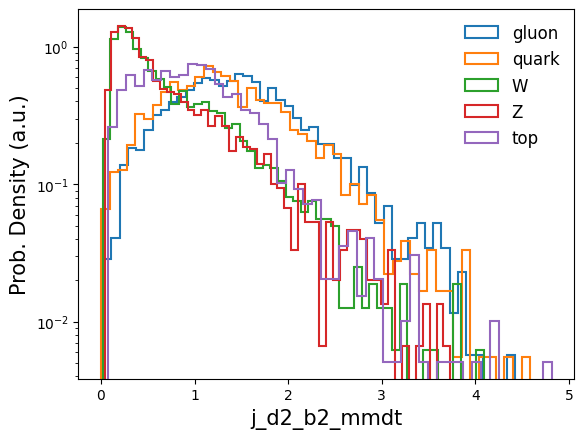

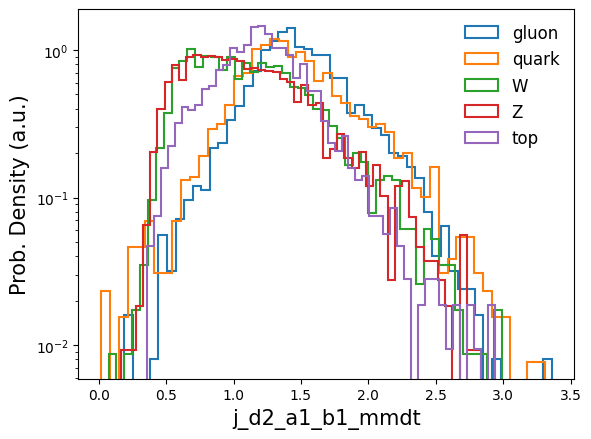

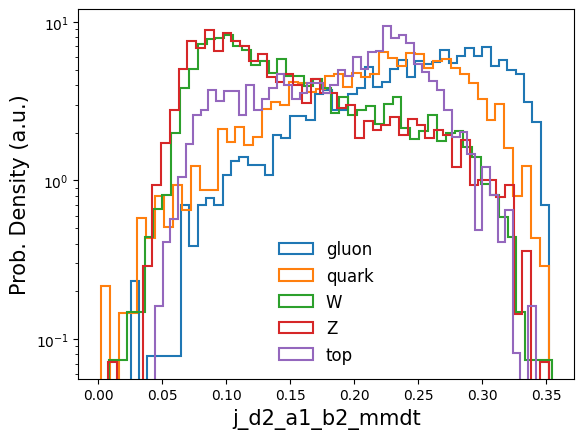

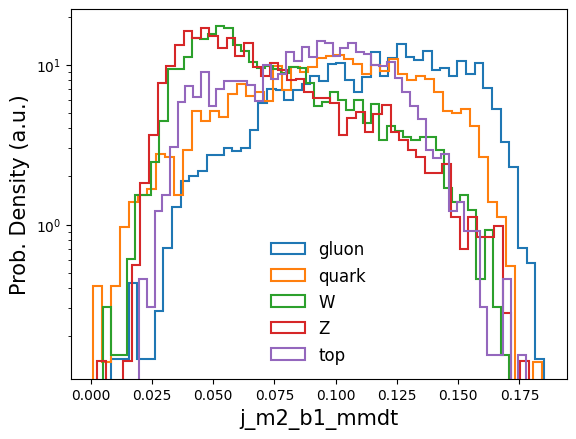

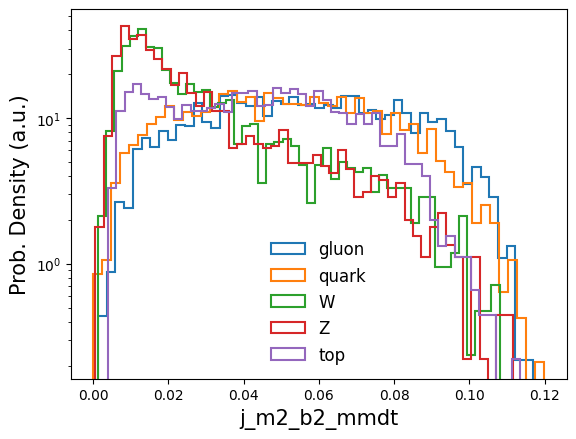

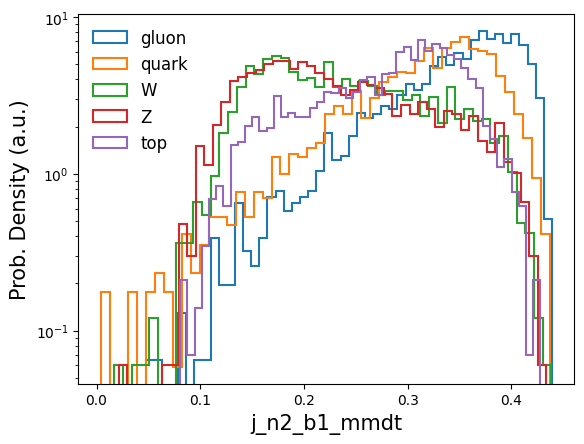

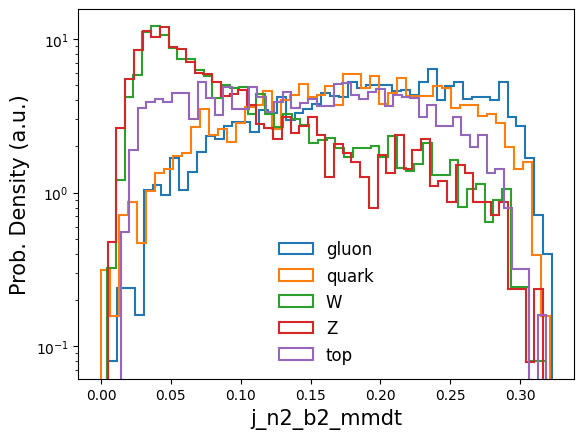

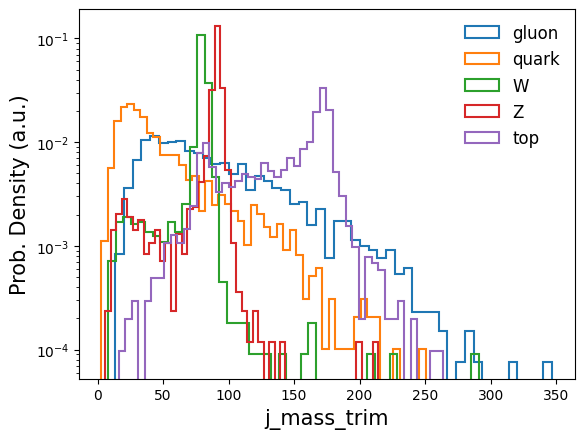

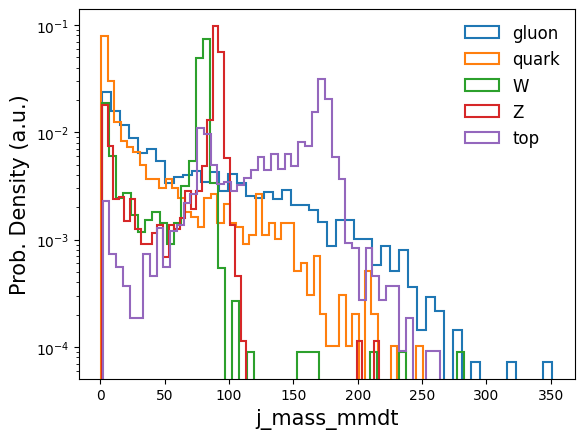

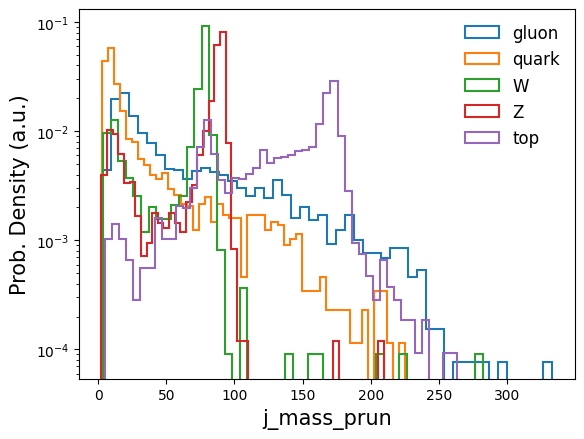

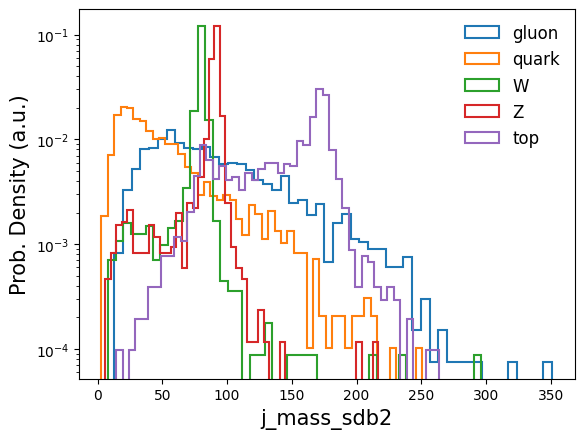

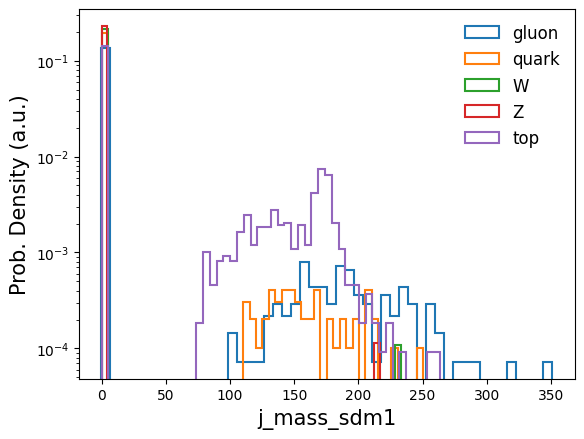

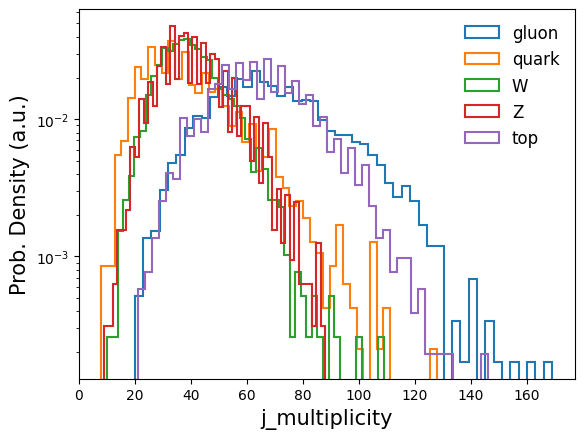

In [18]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
data = np.array(jet_data[:,:-6])
# this function makes the histogram of a given quantity for the five classes
def makePlot(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        # notice the use of numpy masking to select specific classes of jets
        my_data = input_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index], 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')    
    plt.legend(labelCat, fontsize=12, frameon=False)  
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

# we now plot all the features
for i in range(len(featurenames[:-6])):
    makePlot(i, data, featurenames)

# The image dataset

Jets can be converted to images considering the plane of the solid angle orthogonal to the jet direction, centered along the axis direction and binned. In our case, we consider a square of 1.6x1.6 in size (because the jet size is 0.8 in given units) binned in 100x100 equal-size 'cells'.

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/var/folders/vr/sxc1jhmd7b32kypjhkt0yqch0000gn/T/ipykernel_75674/2389791949.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta\eta$ cell", fontsize=15)
/var/folders/vr/sxc1jhmd7b32kypjhkt0yqch0000gn/T/ipykernel_75674/2389791949.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta\phi$ cell", fontsize=15)


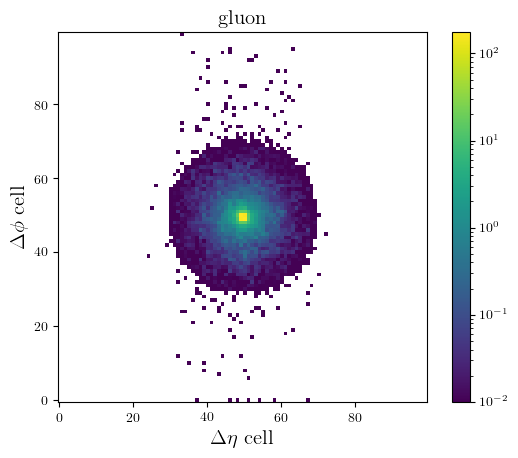

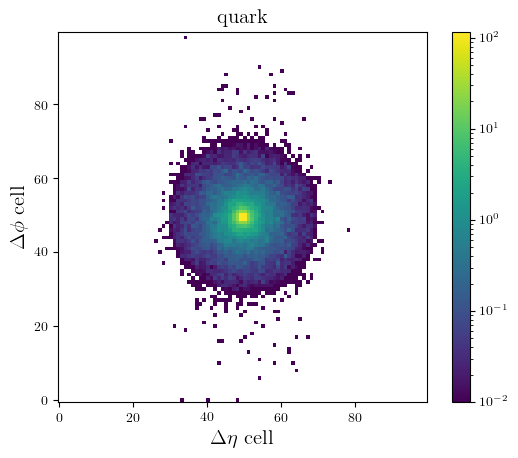

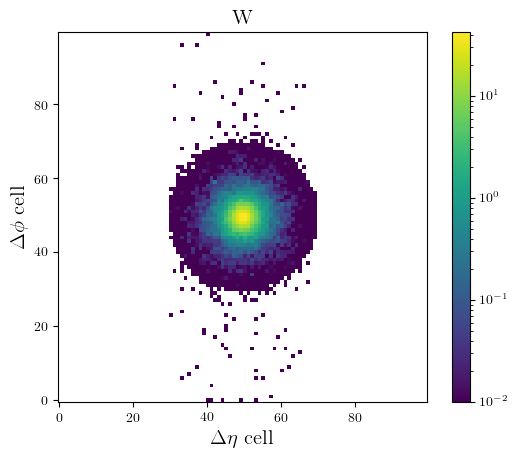

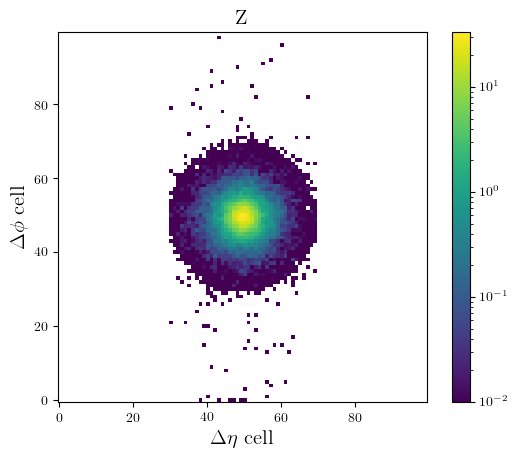

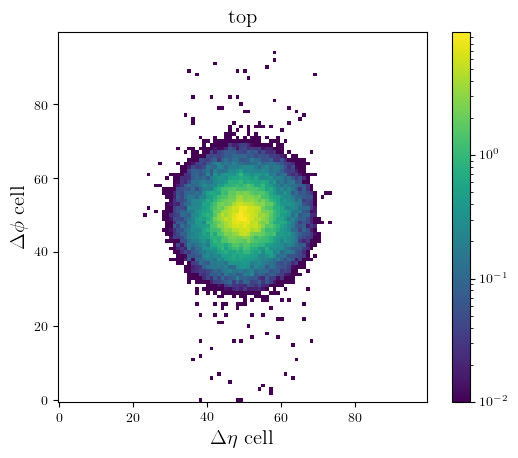

In [19]:
from matplotlib.colors import LogNorm
labelCat= ["gluon", "quark", "W", "Z", "top"]
image = np.array(f.get('jetImage'))
image_g = image[np.argmax(target, axis=1) == 0]
image_q = image[np.argmax(target, axis=1) == 1]
image_W = image[np.argmax(target, axis=1) == 2]
image_Z = image[np.argmax(target, axis=1) == 3]
image_t = image[np.argmax(target, axis=1) == 4]
images = [image_q, image_g, image_W, image_Z, image_t]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0)
    plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
    plt.colorbar()
    plt.title(labelCat[i], fontsize=15)
    plt.xlabel("$\Delta\eta$ cell", fontsize=15)
    plt.ylabel("$\Delta\phi$ cell", fontsize=15)
    plt.show()

# The particle-list dataset

In this case, we look at the particle-related features that we have stored for each jet constituent. The structure of the dataset is similar to that of the physics-motivated features, except for the fact that we have now a double-index dataset: (jet index, particle index). The list is cut at 100 constituents /jet. If less are found, the dataset is completed filling it with 0s (zero padding)

In [20]:
p_featurenames = f.get("particleFeatureNames")
print(p_featurenames[:])

[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


In [21]:
p_data = f.get("jetConstituentList")
print(p_data.shape)

(10000, 100, 16)


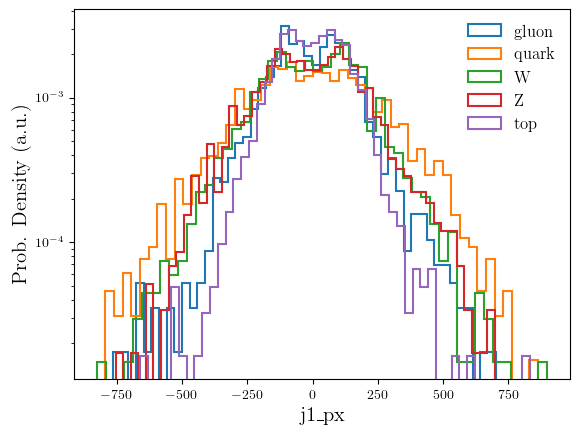

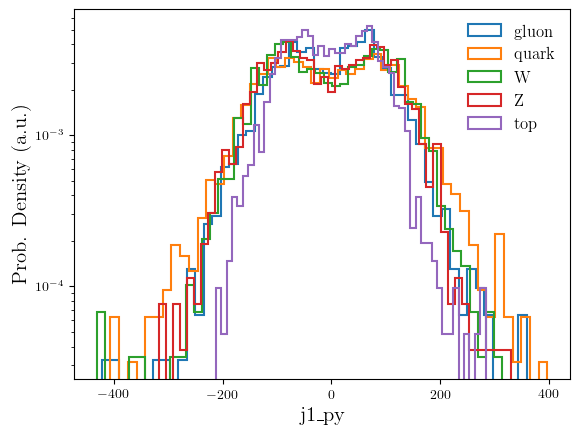

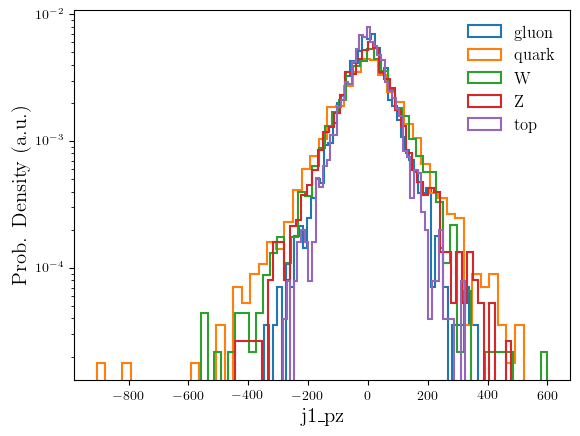

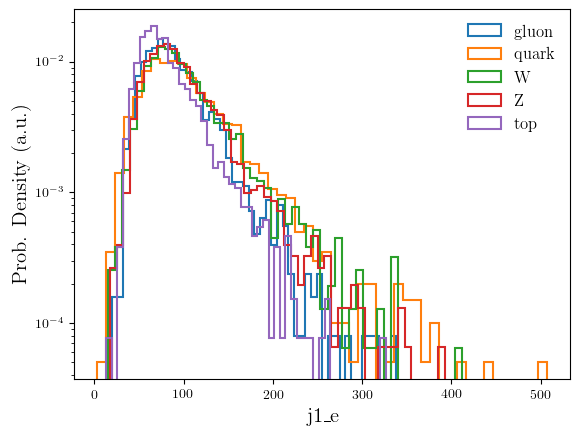

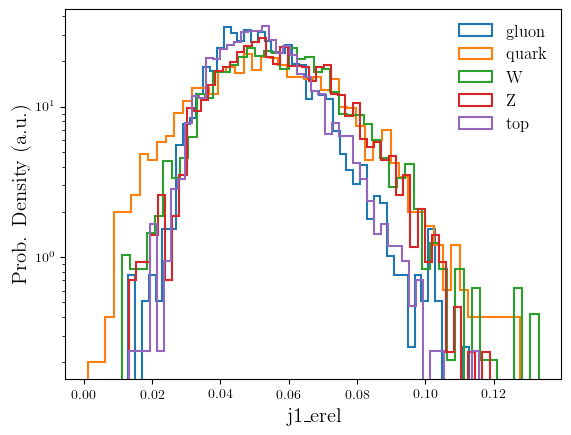

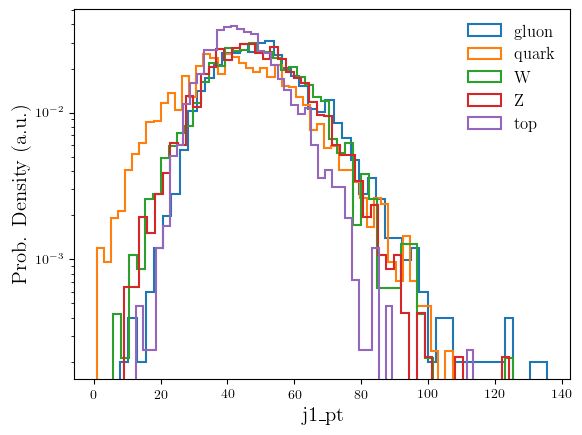

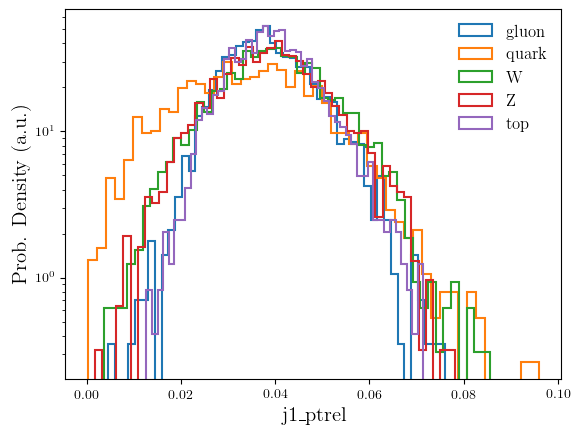

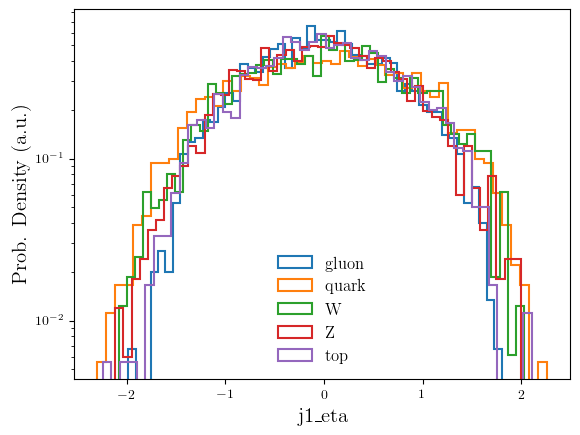

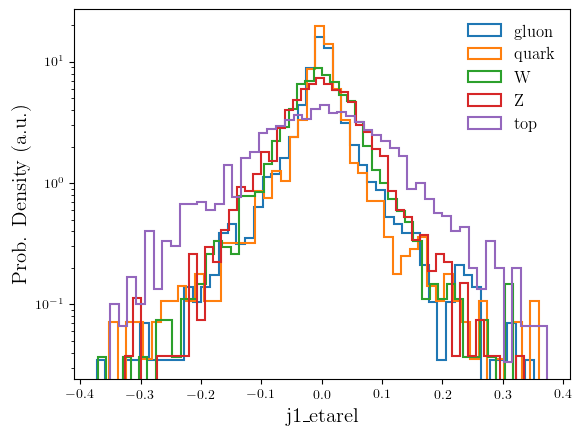

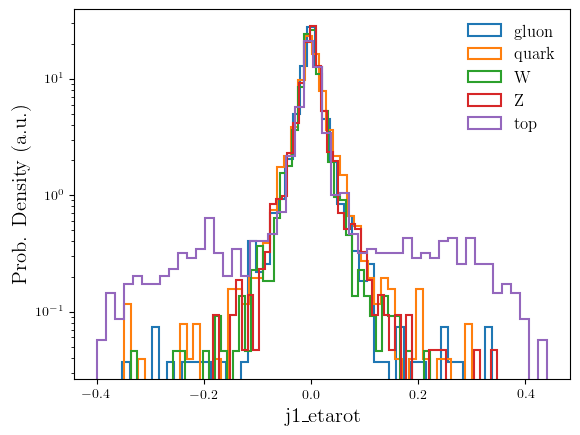

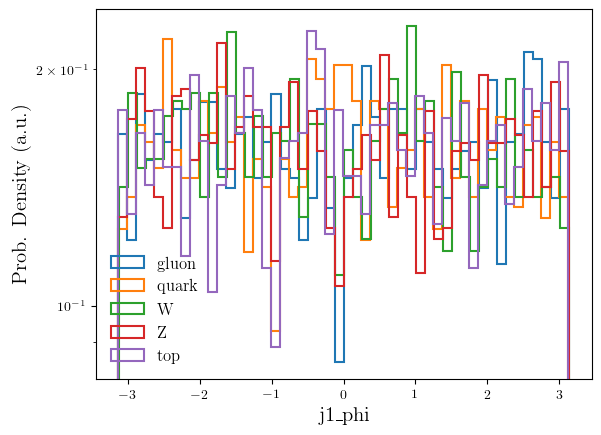

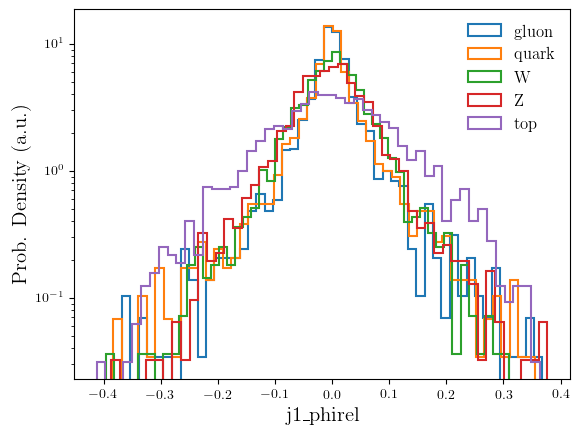

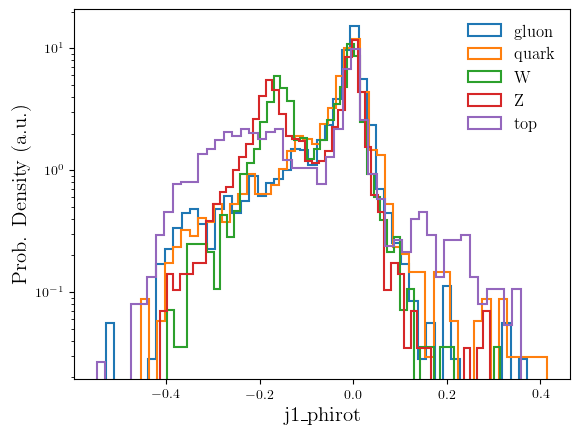

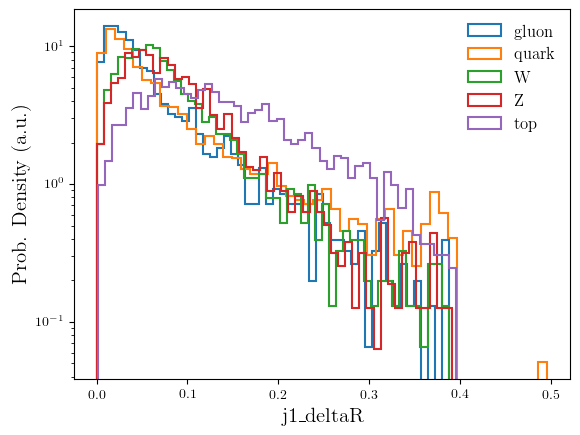

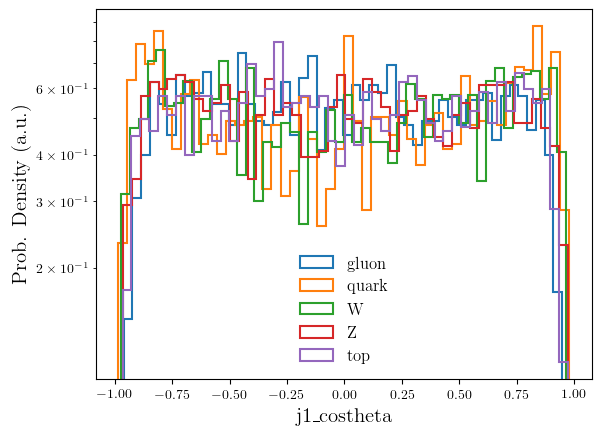

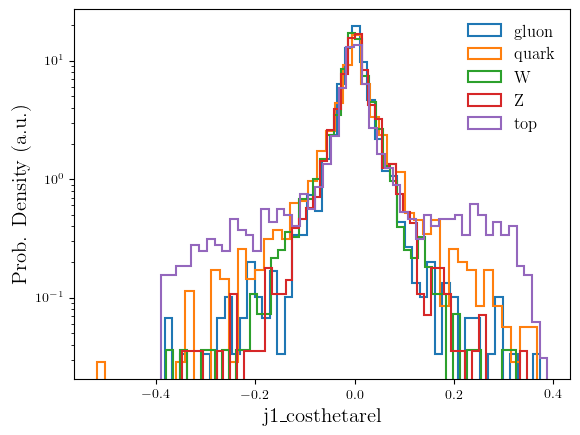

In [22]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot_p(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        my_data = input_data[:,:,feature_index]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')    
    plt.legend(labelCat, fontsize=12, frameon=False)  
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

# we now plot all the features
for i in range(len(p_featurenames)-1):
    makePlot_p(i, p_data, p_featurenames)

# How to read the feature datasets

In [24]:
target = np.array([])
features = np.array([])
# if we cannot load all data on Colab, we just take a few of them
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,:-6])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, features.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 53)


# How to read the image datasets

In [28]:
target = np.array([])
jetImage = np.array([])
# if you are running locallt, you can use the full dataset doing
import glob
for fileIN in glob.glob("tutorials/Data/JetDataset/*100p*h5"):
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, jetImage.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
(80000, 5) (80000, 100, 100)


## NOTICE: we have more, so we can add them if you want

# How to read the list datasets

In [33]:
target = np.array([])
jetList = np.array([])
inputDir = "tutorials/Data/JetDataset/"
# we cannot load all data on Colab. So we just take a few files
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
print(target.shape, jetList.shape)

Appending tutorials/Data/JetDataset//jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset//jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset//jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset//jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset//jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)
